In [1]:
from PIL import Image
import numpy as np
import pandas as pd
from glob import glob
from tqdm import tqdm
from pathlib import Path
import os

import seaborn as sns

import matplotlib.pyplot as plt
import gzip

# MIMIC CXR patients

In [3]:
cxr_root = Path('../../datasets/physionet.org/files/mimic-cxr-jpg/2.0.0/')
! ls $cxr_root

files	     mimic-cxr-2.0.0-chexpert.csv.gz  README
index.html   mimic-cxr-2.0.0-metadata.csv.gz  SHA256SUMS.txt
LICENSE.txt  mimic-cxr-2.0.0-negbio.csv.gz


In [12]:
cxr_df = pd.read_csv(cxr_root / 'mimic-cxr-2.0.0-metadata.csv.gz', header=0, sep=',')

In [244]:
cxr_df = pd.read_csv(cxr_root / 'cxr-study-list.csv.gz', header=0, sep=',')
cxr = pd.DataFrame({'subject_id': cxr_df['subject_id'].unique()})
print(f'total cxr patients: {len(cxr)}')

total cxr patients: 65379


# MIMIC IV

In [119]:
root = Path('../../datasets/physionet.org/files/mimiciv/0.4/')
core = root / 'core'
hosp = root / 'hosp'
icu = root / 'icu'

In [120]:
! ls $core

admissions.csv.gz  index.html  patients.csv.gz	transfers.csv.gz


## patient data

In [126]:
patient_df = pd.read_csv(core / 'patients.csv.gz', header=0, sep=',').merge(cxr)
list(patient_df.keys())

['subject_id',
 'gender',
 'anchor_age',
 'anchor_year',
 'anchor_year_group',
 'dod']

In [128]:
patient_df

,subject_id,gender,anchor_age,anchor_year,anchor_year_group,dod
0,10000764,M,86,2132,2014 - 2016,NaN
1,10001038,M,20,2149,2014 - 2016,NaN
2,10003299,F,65,2173,2008 - 2010,NaN
3,10004235,M,47,2196,2014 - 2016,NaN
4,10004322,M,60,2131,2011 - 2013,NaN
...,...,...,...,...,...,...
65259,19992202,F,80,2153,2014 - 2016,NaN
65260,19992881,M,37,2137,2008 - 2010,NaN
65261,19998350,M,52,2127,2011 - 2013,NaN
65262,19999068,M,63,2161,2011 - 2013,NaN


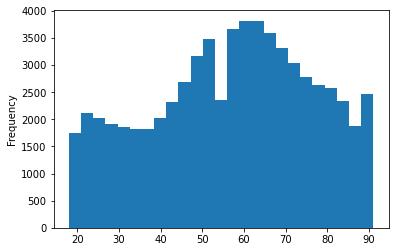

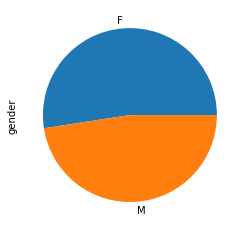

In [129]:
# age dist
patient_df.anchor_age.plot.hist(bins=25)
plt.show()
# sex dist
patient_df.gender.value_counts().plot.pie();

## admission data

In [130]:
admission_df = pd.read_csv(core / 'admissions.csv.gz', header=0, sep=',').merge(cxr)
list(admission_df.keys())

['subject_id',
 'hadm_id',
 'admittime',
 'dischtime',
 'deathtime',
 'admission_type',
 'admission_location',
 'discharge_location',
 'insurance',
 'language',
 'marital_status',
 'ethnicity',
 'edregtime',
 'edouttime',
 'hospital_expire_flag']

In [136]:
admission_df.head()

,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admission_location,discharge_location,insurance,language,marital_status,ethnicity,edregtime,edouttime,hospital_expire_flag
0,13831972,27763544,2131-01-27 04:03:00,2131-01-27 05:39:00,NaN,EU OBSERVATION,EMERGENCY ROOM,NaN,Medicaid,ENGLISH,SINGLE,WHITE,2131-01-26 22:19:00,2131-01-27 05:39:00,0
1,13831972,20914383,2133-03-24 01:12:00,2133-03-24 11:18:00,NaN,EU OBSERVATION,EMERGENCY ROOM,NaN,Medicaid,ENGLISH,SINGLE,WHITE,2133-03-23 17:14:00,2133-03-24 02:18:00,0
2,13831972,28118473,2134-04-23 19:49:00,2134-04-24 14:00:00,NaN,EU OBSERVATION,EMERGENCY ROOM,NaN,Medicaid,ENGLISH,SINGLE,WHITE,2134-04-23 15:38:00,2134-04-23 20:30:00,0
3,13831972,27117659,2131-07-11 01:26:00,2131-07-11 13:52:00,NaN,EU OBSERVATION,EMERGENCY ROOM,NaN,Medicaid,ENGLISH,SINGLE,WHITE,2131-07-10 16:59:00,2131-07-11 02:40:00,0
4,13831972,22890331,2131-06-04 00:21:00,2131-06-05 11:38:00,NaN,EU OBSERVATION,EMERGENCY ROOM,NaN,Medicaid,ENGLISH,SINGLE,WHITE,2131-06-03 17:47:00,2131-06-04 01:47:00,0


In [135]:
len(admission_df.subject_id.unique())

54134

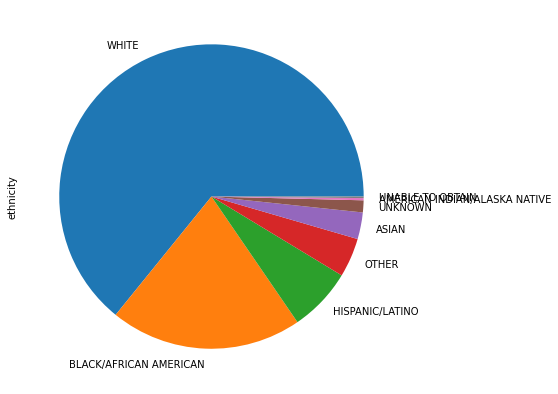

In [132]:
admission_df.ethnicity.value_counts().plot.pie(figsize=(7, 7));

## Transfer

In [137]:
transfer_df = pd.read_csv(core / 'transfers.csv.gz', header=0, sep=',').merge(cxr)

In [138]:
transfer_df.head()

,subject_id,hadm_id,transfer_id,eventtype,careunit,intime,outtime
0,14667207,25131874.0,32319053,discharge,NaN,2152-12-01 16:52:15,NaN
1,14667207,26847855.0,33260165,discharge,NaN,2161-01-15 22:23:15,NaN
2,14667207,25131874.0,37122656,admit,Coronary Care Unit (CCU),2152-11-29 11:25:50,2152-11-30 11:57:35
3,14667207,25131874.0,38878700,transfer,Medicine/Cardiology,2152-11-30 11:57:35,2152-12-01 16:52:15
4,14667207,26847855.0,31152339,ED,Emergency Department,2161-01-07 10:43:00,2161-01-07 13:22:00


## Diagnosis and DRG codes

In [217]:
! ls -lh $hosp
# d_hcpcs.csv.gz, d_icd_diagnoses.csv.gz, d_icd_procedures.csv.gz --> CPT/ICD codes
# d_labitems.csv.gz --> description of lab values

total 4.2G
-rw------- 1 vahid rahulgkgrp 420K Aug 13  2020 d_hcpcs.csv.gz
-rw------- 1 vahid rahulgkgrp  26M Aug 13  2020 diagnoses_icd.csv.gz
-rw------- 1 vahid rahulgkgrp 707K Aug 13  2020 d_icd_diagnoses.csv.gz
-rw------- 1 vahid rahulgkgrp 552K Aug 13  2020 d_icd_procedures.csv.gz
-rw------- 1 vahid rahulgkgrp  15K Aug 13  2020 d_labitems.csv.gz
-rw------- 1 vahid rahulgkgrp  13M Aug 13  2020 drgcodes.csv.gz
-rw------- 1 vahid rahulgkgrp 495M Aug 13  2020 emar.csv.gz
-rw------- 1 vahid rahulgkgrp 458M Aug 13  2020 emar_detail.csv.gz
-rw------- 1 vahid rahulgkgrp 1.4M Aug 13  2020 hcpcsevents.csv.gz
-rw------- 1 vahid rahulgkgrp 2.3K Oct 21 22:32 index.html
-rw------- 1 vahid rahulgkgrp 2.0G Aug 13  2020 labevents.csv.gz
-rw------- 1 vahid rahulgkgrp  16M Aug 13  2020 microbiologyevents.csv.gz
-rw------- 1 vahid rahulgkgrp 404M Aug 13  2020 pharmacy.csv.gz
-rw------- 1 vahid rahulgkgrp 479M Aug 13  2020 poe.csv.gz
-rw------- 1 vahid rahulgkgrp  23M Aug 13  2020 poe_detail.csv.gz
-rw

In [151]:
icd = pd.read_csv(hosp / 'diagnoses_icd.csv.gz', header=0, sep=',').merge(cxr)

In [185]:
print(f'patients with cxr: {len(icd.subject_id.unique())}')
icd.head()

patients with cxr: 53576


,subject_id,hadm_id,seq_num,icd_code,icd_version
0,11603789,25552978,3,65801,9
1,11603789,25552978,4,64881,9
2,11603789,25552978,5,V270,9
3,11603789,25552978,1,65221,9
4,11603789,25552978,2,64421,9


In [188]:
# primary reason for hospitalization
drg = pd.read_csv(hosp / 'drgcodes.csv.gz', header=0, sep=',').merge(cxr).drop_duplicates()

In [189]:
drg.head()

,subject_id,hadm_id,drg_type,drg_code,description,drg_severity,drg_mortality
0,11603789,25552978,APR,5402,Cesarean Delivery,2.0,1.0
2,11603789,25552978,HCFA,765,CESAREAN SECTION W CC/MCC,NaN,NaN
3,11603789,24766658,APR,5401,Cesarean Delivery,1.0,1.0
5,11603789,24766658,HCFA,766,CESAREAN SECTION W/O CC/MCC,NaN,NaN
6,11603789,20536278,APR,5401,Cesarean Delivery,1.0,1.0


In [204]:
drg[drg.drg_type=='APR'].description.value_counts()[:20]

Heart Failure                                                      7323
Septicemia & Disseminated Infections                               6557
Other Pneumonia                                                    4053
Chemotherapy                                                       3375
Renal Failure                                                      3350
Kidney & Urinary Tract Infections                                  3223
Other Digestive System Diagnoses                                   2719
Cardiac Arrhythmia & Conduction Disorders                          2634
Percutaneous Cardiovascular Procedures w/o AMI                     2529
Cellulitis & Other Bacterial Skin Infections                       2490
Other Vascular Procedures                                          2306
CVA & Precerebral Occulusion w/ Infarct                            2193
Chronic Obstructive Pulmonary Disease                              2134
Seizure                                                         

## Medication

In [198]:
# emar.csv.gz, emar_detail.csv.gz
# pharmacy.csv.gz 
# poe.csv.gz poe_detail.csv.gz
# prescriptions.csv.gz

### We can use 'poe' to only focus on specific 'hadm_id' / time 

In [246]:
poe = pd.read_csv(hosp / 'poe.csv.gz', header=0, sep=',').merge(cxr).drop_duplicates()

In [255]:
poe.order_type.unique()

array(['Medications', 'Lab', 'Radiology', 'Cardiology', 'Nutrition',
       'General Care', 'IV therapy', 'ADT orders', 'Blood Bank',
       'Consults', 'Respiratory', 'Critical Care', 'TPN', 'Hemodialysis',
       'Neurology', 'OB'], dtype=object)

In [250]:
poe[poe.order_type == 'Radiology'].order_subtype.unique()

array(['General Xray', 'Ultrasound', 'CT Scan', 'Nuclear Med',
       'Noninvasive Vascular', 'MRI', 'Interventional Radiology', 'Angio',
       'Cross-Sectional Interventional Radiology', 'Interventional Neuro',
       nan], dtype=object)

In [252]:
poe.subject_id.unique().shape

(54011,)

In [254]:
poe[poe.order_type == 'Radiology'].subject_id.unique().shape

(50453,)

In [256]:
poe[poe.order_subtype == 'General Xray'].subject_id.unique().shape

(48260,)

## Lab measurements

### Probably a good option is to choose top-n common lab measurements at the same time of chest x-ray prescription.

In [234]:
lab_items = pd.read_csv(hosp / 'd_labitems.csv.gz', header=0, sep=',') 

In [306]:
# lab_items.dropna()[lab_items.dropna().label.str.contains('ox', case=False)]

In [282]:
lab_items.fluid.unique()

array(['Other Body Fluid', 'Blood', 'Urine', 'Stool', 'Bone Marrow',
       'Ascites', 'Cerebrospinal Fluid', 'Joint Fluid', 'Pleural',
       'Fluid', 'I', 'Q'], dtype=object)

In [219]:
lab = pd.read_csv(hosp / 'labevents.csv.gz', header=0, sep=',', chunksize=10000)

In [307]:
cnt = 0
for chunck in lab:
    sample = chunck
    break

In [312]:
sample.head()

,labevent_id,subject_id,hadm_id,specimen_id,itemid,charttime,storetime,value,valuenum,valueuom,ref_range_lower,ref_range_upper,flag,priority,comments
98280000,88229880,17092962,27938771.0,47706922,50863,2116-07-13 05:00:00,2116-07-13 08:13:00,70,70.0,IU/L,35.0,105.0,NaN,ROUTINE,NaN
98280001,88229881,17092962,27938771.0,47706922,50868,2116-07-13 05:00:00,2116-07-13 06:22:00,16,16.0,mEq/L,8.0,20.0,NaN,ROUTINE,NaN
98280002,88229882,17092962,27938771.0,47706922,50878,2116-07-13 05:00:00,2116-07-13 08:13:00,18,18.0,IU/L,0.0,40.0,NaN,ROUTINE,NaN
98280003,88229883,17092962,27938771.0,47706922,50882,2116-07-13 05:00:00,2116-07-13 06:22:00,23,23.0,mEq/L,22.0,32.0,NaN,ROUTINE,NaN
98280004,88229884,17092962,27938771.0,47706922,50885,2116-07-13 05:00:00,2116-07-13 08:13:00,0.5,0.5,mg/dL,0.0,1.5,NaN,ROUTINE,NaN


In [340]:
sample.merge(cxr).subject_id.unique().shape[0] / sample.subject_id.unique().shape[0] 

0.25

In [309]:
lab_items[lab_items.itemid.isin((sample.itemid.value_counts()[:10]).index)]

,itemid,label,fluid,category,loinc_code
512,50912,Creatinine,Blood,Chemistry,2160-0
761,51221,Hematocrit,Blood,Hematology,4544-3
771,51222,Hemoglobin,Blood,Hematology,718-7
1013,51248,MCH,Blood,Hematology,785-6
1014,51249,MCHC,Blood,Hematology,786-4
1016,51250,MCV,Blood,Hematology,787-2
1211,51265,Platelet Count,Blood,Hematology,777-3
1307,51277,RDW,Blood,Hematology,788-0
1312,51279,Red Blood Cells,Blood,Hematology,789-8
1598,51301,White Blood Cells,Blood,Hematology,804-5


## Microbiology

In [327]:
# checks for infectious growth
micro = pd.read_csv(hosp / 'microbiologyevents.csv.gz', header=0, sep=',', low_memory=False).merge(cxr)

In [323]:
micro.subject_id.unique().shape

(28582,)

In [325]:
micro.head()

,microevent_id,subject_id,hadm_id,micro_specimen_id,chartdate,charttime,spec_itemid,spec_type_desc,test_seq,storedate,...,org_name,isolate_num,quantity,ab_itemid,ab_name,dilution_text,dilution_comparison,dilution_value,interpretation,comments
0,1562,10004235,NaN,139903,2196-02-24 00:00:00,2196-02-24 12:40:00,70012,BLOOD CULTURE,1,2196-02-27 00:00:00,...,ESCHERICHIA COLI,1.0,NaN,90013.0,TOBRAMYCIN,<=1,<=,1.0,S,NaN
1,1558,10004235,NaN,139903,2196-02-24 00:00:00,2196-02-24 12:40:00,70012,BLOOD CULTURE,1,2196-02-27 00:00:00,...,ESCHERICHIA COLI,1.0,NaN,90004.0,AMPICILLIN,8,=,8.0,S,NaN
2,1559,10004235,NaN,139903,2196-02-24 00:00:00,2196-02-24 12:40:00,70012,BLOOD CULTURE,1,2196-02-27 00:00:00,...,ESCHERICHIA COLI,1.0,NaN,90005.0,CEFAZOLIN,<=4,<=,4.0,S,NaN
3,1560,10004235,NaN,139903,2196-02-24 00:00:00,2196-02-24 12:40:00,70012,BLOOD CULTURE,1,2196-02-27 00:00:00,...,ESCHERICHIA COLI,1.0,NaN,90008.0,TRIMETHOPRIM/SULFA,<=1,<=,1.0,S,NaN
4,1561,10004235,NaN,139903,2196-02-24 00:00:00,2196-02-24 12:40:00,70012,BLOOD CULTURE,1,2196-02-27 00:00:00,...,ESCHERICHIA COLI,1.0,NaN,90012.0,GENTAMICIN,<=1,<=,1.0,S,NaN


## ICU

### Which ICU measurements should we use?

In [329]:
! ls -lh $icu

total 2.6G
-rw------- 1 vahid rahulgkgrp 2.2G Aug 13  2020 chartevents.csv.gz
-rw------- 1 vahid rahulgkgrp  39M Aug 13  2020 datetimeevents.csv.gz
-rw------- 1 vahid rahulgkgrp  56K Aug 13  2020 d_items.csv.gz
-rw------- 1 vahid rahulgkgrp 2.6M Aug 13  2020 icustays.csv.gz
-rw------- 1 vahid rahulgkgrp 1.1K Oct 21 22:32 index.html
-rw------- 1 vahid rahulgkgrp 314M Aug 13  2020 inputevents.csv.gz
-rw------- 1 vahid rahulgkgrp  34M Aug 13  2020 outputevents.csv.gz
-rw------- 1 vahid rahulgkgrp  19M Aug 13  2020 procedureevents.csv.gz


In [331]:
d_items = pd.read_csv(icu / 'd_items.csv.gz', header=0, sep=',')

In [354]:
d_items.head()

,itemid,label,abbreviation,linksto,category,unitname,param_type,lownormalvalue,highnormalvalue
0,220003,ICU Admission date,ICU Admission date,datetimeevents,ADT,NaN,Date and time,NaN,NaN
1,220045,Heart Rate,HR,chartevents,Routine Vital Signs,bpm,Numeric,NaN,NaN
2,220046,Heart rate Alarm - High,HR Alarm - High,chartevents,Alarms,bpm,Numeric,NaN,NaN
3,220047,Heart Rate Alarm - Low,HR Alarm - Low,chartevents,Alarms,bpm,Numeric,NaN,NaN
4,220048,Heart Rhythm,Heart Rhythm,chartevents,Routine Vital Signs,NaN,Text,NaN,NaN


In [349]:
# d_items[d_items.label.str.contains('oxygen', case=False)]

In [350]:
datetimeevents = pd.read_csv(icu / 'datetimeevents.csv.gz', header=0, sep=',').merge(cxr)

In [337]:
datetimeevents.subject_id.unique().shape

(19914,)